In [2]:
# %matplotlib nbagg
# import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# from scipy.optimize import curve_fit

inputFilePath = 'C:\\Researches\\Data\\CrBr3\\202110\\RIXS\\'

base = 'Cr'
energyDispersion = 0.005356 #eV/subpixel

In [6]:
def xCorr(refData, uncorrData):
    corr = signal.correlate(refData[1950:2050], uncorrData[1950:2050])
    lags = signal.correlation_lags(len(refData[1950:2050]), len(uncorrData[1950:2050]))
    lag = lags[np.argmax(corr)]
    corrData = np.roll(uncorrData, lag)
    return corrData

def elasticShift(pixelData):

    global energyDispersion

    peaks, _ = signal.find_peaks(pixelData,height=20,width=5)
    xdataPixel = np.arange(len(pixelData))
    
    xdataPixel = xdataPixel[(peaks[-1]-2000):(peaks[-1]+200)]
    energyData = pixelData[(peaks[-1]-2000):(peaks[-1]+200)]
    
    xDataEnergy = (xdataPixel - peaks[-1]) * energyDispersion * -1

    return [xDataEnergy,energyData]

def getdata(scannumber):
    global inputFilePath
    global base
    
    if scannumber < 10:
        filename = base+"_"+"000"+str(scannumber)
    elif scannumber < 100:
        filename = base+"_"+"00"+str(scannumber)
    elif scannumber < 1000:    
        filename = base+"_"+"0"+str(scannumber)
    else:    
        filename = base+"_"+str(scannumber)

    f1 = h5py.File(inputFilePath+filename+"_d1.h5", 'r')
    f2 = h5py.File(inputFilePath+filename+"_d2.h5", 'r')
    f3 = h5py.File(inputFilePath+filename+"_d3.h5", 'r')

    ccd1 = f1['entry']['analysis']['spectrum'][()]
    ccd2 = f2['entry']['analysis']['spectrum'][()]
    ccd3 = f3['entry']['analysis']['spectrum'][()]
    
    [xdata,data1] = elasticShift(ccd1)
    [_,data2] = elasticShift(ccd2)
    [_,data3] = elasticShift(ccd3)

    data1=xCorr(data2,data1)
    data3=xCorr(data2,data3)

    tempData = (data1+data2+data3)/3
    data = [xdata,tempData]
    
    return data





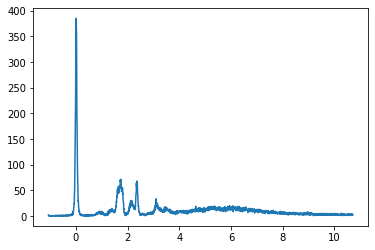

In [7]:
fig = plt.figure()
[X,Y]=getdata(50)
plt.plot(X,Y)
plt.show()

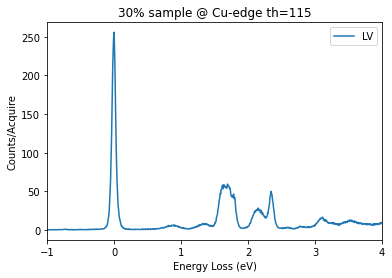

In [11]:
fig = plt.figure() 

#####################################

scans = np.arange(21,30+1)
sumData = np.zeros(2200)

for i,s in enumerate(scans):
    [xData,oneData] = getdata(s)
    if i == 0:
        refData = oneData
    else:
        oneData = xCorr(refData,oneData)
    sumData = sumData+oneData
aveData = sumData/len(scans)

plt.plot(xData,aveData,  label='LV')

######################################

plt.xlabel('Energy Loss (eV)')
plt.ylabel('Counts/Acquire')
plt.xlim([-1,4])
plt.title('30% sample @ Cu-edge th=115')
plt.legend()
plt.show()

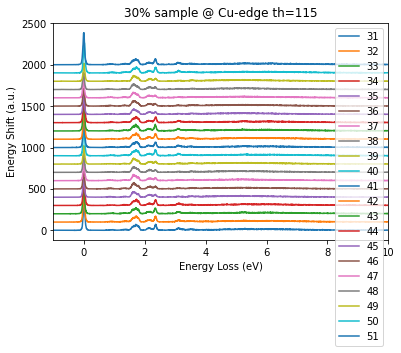

In [16]:
fig = plt.figure()

scans = np.arange(31,51+1)

sumData = np.zeros(2200)

for i,s in enumerate(scans):
    [xData,oneData] = getdata(s)
    plt.plot(xData,oneData+100*i,label=str(s))

plt.xlabel('Energy Loss (eV)')
plt.ylabel('Energy Shift (a.u.)')
plt.xlim([-1,10])
plt.title('30% sample @ Cu-edge th=115')
plt.legend(loc='upper right')

Text(0.5, 1.0, '30% sample @ Cu-edge th=115')

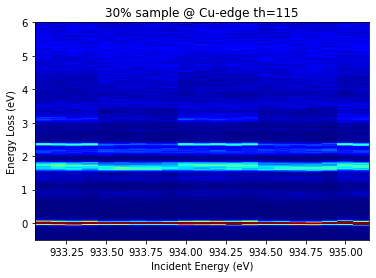

In [17]:
fig = plt.figure()

scans = np.arange(31,51+1)
Ei = np.arange(933.1,935.1+0.05,0.1)
eiNum = len(scans)

matrixData = np.zeros((2200, eiNum))

for i,s in enumerate(scans):
    [Eloss,oneData] = getdata(s)
    matrixData[:,i] = oneData.T

X,Y = np.meshgrid(Ei,Eloss)

plt.pcolormesh(X,Y,matrixData,shading='auto',cmap='jet',vmax=150)
plt.ylim([-0.5,10])
plt.xlabel('Incident Energy (eV)')
plt.ylabel('Energy Loss (eV)')
plt.title('30% sample @ Cu-edge th=115')